In [119]:
%matplotlib notebook
# Import packages
import h5py
import numpy as np

import sigpy as sp
from sigpy import backend, linop, prox, util
from sigpy.alg import (PowerMethod, GradientMethod,
                       ConjugateGradient, PrimalDualHybridGradient)
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
import os

# %matplotlib inline
# where to find the file cfl.py
# cflpath = "../bart/python"
# sys.path.append(os.path.abspath(cflpath))
import cfl
from bart import bart

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

gpu_number = -1 # CPU 

coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_brain = rawdata[0,:,:,:].transpose((2,0,1))
rawdata_brain = sp.backend.to_device(rawdata_brain,gpu_number)

<IPython.core.display.Javascript object>


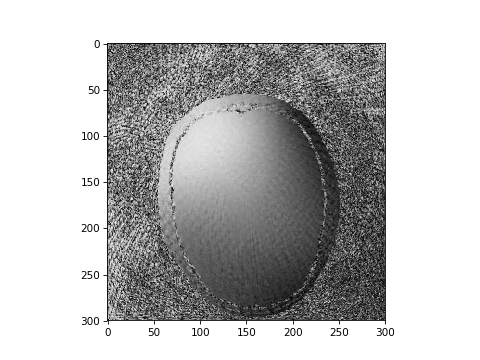

In [5]:
# generating coil sensitivity profiles
image = cfl.readcfl("img_igrid_brain")
image_sos = sp.util.rss(image,3)
sens_maps = image[:,:,0,:]/image_sos
sens_maps_t = sens_maps.transpose((2,0,1))
sens_maps_t = sp.backend.to_device(sens_maps_t,gpu_number)

plt.figure()
plt.imshow(np.abs(sens_maps_t[0,:,:]).reshape(300,300),"gray")

In [12]:
import numpy as np

In [99]:
# Modify conjugate gradient algorithm to output a different residual
class ConjugateGradient_rrsg(sp.alg.Alg):
    r"""Conjugate Gradient Method. Solves for:

    .. math:: A x = b

    where A is hermitian.

    Args:
        A (Linop or function): Linop or function to compute A.
        b (array): Observation.
        x (array): Variable.
        P (function or None): Preconditioner.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for stopping condition.

    """

    def __init__(self, A, b, x, P=None, max_iter=100, tol=0):
        self.A = A
        self.P = P
        self.x = x
        self.b = b
        self.tol = tol
        self.device = backend.get_device(x)
        with self.device:
            xp = self.device.xp
            self.r = b - self.A(self.x)
#             self.r = A.H*b - self.A.H(self.A(self.x))

            if self.P is None:
                z = self.r
            else:
                z = self.P(self.r)

            if max_iter > 1:
                self.p = z.copy()
            else:
                self.p = z

            self.not_positive_definite = False
            self.rzold = xp.real(xp.vdot(self.r, z))
#             self.resid = self.rzold.item()**0.5
#             print(A.H.oshape,A.H.ishape)
#             print(b.shape,b.shape)
#             print(self.x.shape,self.x.shape)
#             self.resid = xp.linalg.norm(A.H*b - self.A.H*(self.A*(self.x)))/xp.linalg.norm(self.A.H*(self.b))
        super().__init__(max_iter)


    def _update(self):
        with self.device:
            xp = self.device.xp
            Ap = self.A(self.p)
            pAp = xp.real(xp.vdot(self.p, Ap)).item()
            if pAp <= 0:
                self.not_positive_definite = True
                return

            self.alpha = self.rzold / pAp
            util.axpy(self.x, self.alpha, self.p)
            if self.iter < self.max_iter - 1:
                util.axpy(self.r, -self.alpha, Ap)
                if self.P is not None:
                    z = self.P(self.r)
                else:
                    z = self.r

                rznew = xp.real(xp.vdot(self.r, z))
                beta = rznew / self.rzold
                util.xpay(self.p, beta, z)
                self.rzold = rznew
                
#             self.resid = util.norm2(self.r)/util.norm2(self.A.H(self.b))
            self.resid = self.rzold.item()**0.5

    def _done(self):
        return (self.iter >= self.max_iter or
                self.not_positive_definite)


In [92]:
# Build a sigpy app that takes a referenz image and computes difference in each iteration
class LinearLeastSquares_ref(sp.app.LinearLeastSquares):
    def __init__(self, A, y, x=None, proxg=None,
                 lamda=0, G=None, g=None, R=None, mu=0, z=0,
                 alg_name=None, max_iter=100,
                 P=None, alpha=None, max_power_iter=30, accelerate=True,
                 tau=None, sigma=None,
                 save_objective_values=True, show_pbar=True, reference_image=None, save_res=True):
        self.A = A
        self.y = y
        self.x = x
        self.proxg = proxg
        self.lamda = lamda
        self.G = G
        self.g = g
        self.R = R
        self.mu = mu
        self.z = z
        self.alg_name = alg_name
        self.max_iter = max_iter
        self.P = P
        self.alpha = alpha
        self.max_power_iter = max_power_iter
        self.accelerate = accelerate
        self.tau = tau
        self.sigma = sigma
        self.save_objective_values = save_objective_values
        self.show_pbar = show_pbar
        self.reference_image = reference_image
        self.save_res = save_res
        
        self.y_device = backend.get_device(y)
        if self.x is None:
            with self.y_device:
                self.x = self.y_device.xp.zeros(A.ishape, dtype=y.dtype)

        self.x_device = backend.get_device(self.x)
#         self._get_alg()
        self._get_ConjugateGradient_rrsg()
        
        if self.save_objective_values:
            self.objective_values = []
        
        if self.save_res:
            self.res = [] # residual
            
        if self.reference_image is not None:
            self.diff_to_reference = []

    def get_diff_to_reference(self):
        with self.y_device:
            r = self.x - self.reference_image
            diff = self.y_device.xp.linalg.norm(r)
        return util.asscalar(diff)
            
    def _summarize(self):
        if self.save_objective_values:
            self.objective_values.append(self.objective())
        
        if self.save_res:
            self.res.append(self.alg.resid)
            
        if self.reference_image is not None:
            self.diff_to_reference.append(self.get_diff_to_reference())
            
        if self.show_pbar:
            if self.save_objective_values:
                self.pbar.set_postfix(
                    obj='{0:.2E}'.format(self.objective_values[-1]))
            else:
                self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))        
    
    def _get_ConjugateGradient_rrsg(self):
        I = linop.Identity(self.x.shape)
        AHA = self.A.H * self.A
        AHy = self.A.H(self.y)

        if self.lamda != 0:
            if self.R is None:
                AHA += self.lamda * I
            else:
                AHA += self.lamda * self.R.H * self.R

        if self.mu != 0:
            AHA += self.mu * I
            util.axpy(AHy, self.mu, self.z)
        
#         self.alg = sp.alg.ConjugateGradient(
#             AHA, AHy, self.x, P=self.P, max_iter=self.max_iter)

        self.alg = ConjugateGradient_rrsg(
            AHA, AHy, self.x, P=self.P, max_iter=self.max_iter)

            
    def _post_update(self):

        return
        



<IPython.core.display.Javascript object>


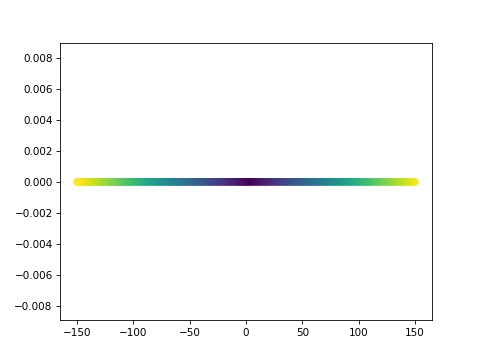

<IPython.core.display.Javascript object>

E output shape = [12, 512, 96]
DCF shape = (512, 96)
A input shape = [1, 300, 300]
A output shape = [12, 512, 96]


In [97]:
# Define density compensation
def get_dcf(coor):
    dcf = np.linalg.norm(coor,axis=2)
    ind = np.where(dcf == 0)
    dcf[ind] = dcf[ind[0]+1, ind[1]]*1/8
    return dcf

# Compose linear operators
img_shape = (1,300,300)
S = sp.linop.Multiply(img_shape,sens_maps_t)
NUFFT = sp.linop.NUFFT(S.oshape,coor)
E = NUFFT*S
dcf = get_dcf(coor)

plt.figure()
plt.scatter(coor[:,0,0],coor[:,0,1],c=dcf[:,0])
plt.figure()
plt.plot(dcf[:,0])

D = sp.linop.Multiply(E.oshape,np.sqrt(dcf))
A = D*E
print("E output shape = {}".format(E.oshape))
print("DCF shape = {}".format(dcf.shape))
print("A input shape = {}".format(A.ishape))
print("A output shape = {}".format(A.oshape))


In [23]:
A.oshape

[12, 512, 96]

In [22]:
(D*rawdata_brain).shape

(12, 512, 96)

In [41]:
AA = A.H

In [43]:
AA.oshape

[1, 300, 300]

In [107]:
s = LinearLeastSquares_ref(A,D*rawdata_brain,max_iter=10)
img_rec_iter10 = s.run()
img_rec_iter10_gpu = sp.backend.to_device(img_rec_iter10,-1)






LinearLeastSquares_ref:   0%|          | 0/10 [00:00<?, ?it/s]



LinearLeastSquares_ref:   0%|          | 0/10 [00:00<?, ?it/s, obj=2.38E-02]



LinearLeastSquares_ref:  10%|█         | 1/10 [00:00<00:06,  1.35it/s, obj=2.38E-02]



LinearLeastSquares_ref:  10%|█         | 1/10 [00:01<00:06,  1.35it/s, obj=2.08E-02]



LinearLeastSquares_ref:  20%|██        | 2/10 [00:01<00:05,  1.37it/s, obj=2.08E-02]



LinearLeastSquares_ref:  20%|██        | 2/10 [00:02<00:05,  1.37it/s, obj=2.06E-02]



LinearLeastSquares_ref:  30%|███       | 3/10 [00:02<00:05,  1.39it/s, obj=2.06E-02]



LinearLeastSquares_ref:  30%|███       | 3/10 [00:02<00:05,  1.39it/s, obj=2.05E-02]



LinearLeastSquares_ref:  40%|████      | 4/10 [00:02<00:04,  1.41it/s, obj=2.05E-02]



LinearLeastSquares_ref:  40%|████      | 4/10 [00:03<00:04,  1.41it/s, obj=2.05E-02]



LinearLeastSquares_ref:  50%|█████     | 5/10 [00:03<00:03,  1.42it/s, obj=2.05E-02]



LinearLeastSquares_ref:  50%|█████     | 5/10 [00:04<00:03

In [108]:
s = LinearLeastSquares_ref(A,D*rawdata_brain,max_iter=20,reference_image=img_rec_iter10_gpu)
img_rec_now = s.run()





LinearLeastSquares_ref:   0%|          | 0/20 [00:00<?, ?it/s]



LinearLeastSquares_ref:   0%|          | 0/20 [00:00<?, ?it/s, obj=2.38E-02]



LinearLeastSquares_ref:   5%|▌         | 1/20 [00:00<00:12,  1.49it/s, obj=2.38E-02]



LinearLeastSquares_ref:   5%|▌         | 1/20 [00:01<00:12,  1.49it/s, obj=2.08E-02]



LinearLeastSquares_ref:  10%|█         | 2/20 [00:01<00:11,  1.53it/s, obj=2.08E-02]



LinearLeastSquares_ref:  10%|█         | 2/20 [00:01<00:11,  1.53it/s, obj=2.06E-02]



LinearLeastSquares_ref:  15%|█▌        | 3/20 [00:01<00:11,  1.51it/s, obj=2.06E-02]



LinearLeastSquares_ref:  15%|█▌        | 3/20 [00:02<00:11,  1.51it/s, obj=2.05E-02]



LinearLeastSquares_ref:  20%|██        | 4/20 [00:02<00:10,  1.51it/s, obj=2.05E-02]



LinearLeastSquares_ref:  20%|██        | 4/20 [00:03<00:10,  1.51it/s, obj=2.05E-02]



LinearLeastSquares_ref:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s, obj=2.05E-02]



LinearLeastSquares_ref:  25%|██▌       | 5/20 [00:03<00:09

<IPython.core.display.Javascript object>


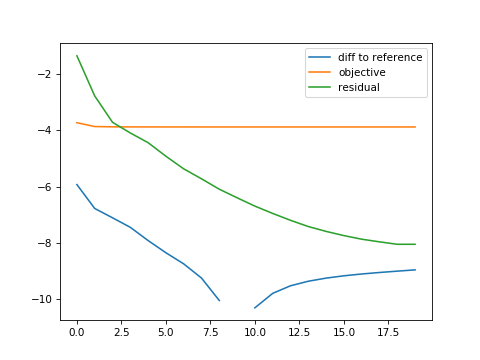

/home/kewang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [109]:
plt.figure()
plt.plot(np.log(s.diff_to_reference),label='diff to reference')
plt.plot(np.log(s.objective_values),label='objective')
plt.plot(np.log(s.res),label="residual")
plt.legend()
plt.show()

(300, 300)


<IPython.core.display.Javascript object>


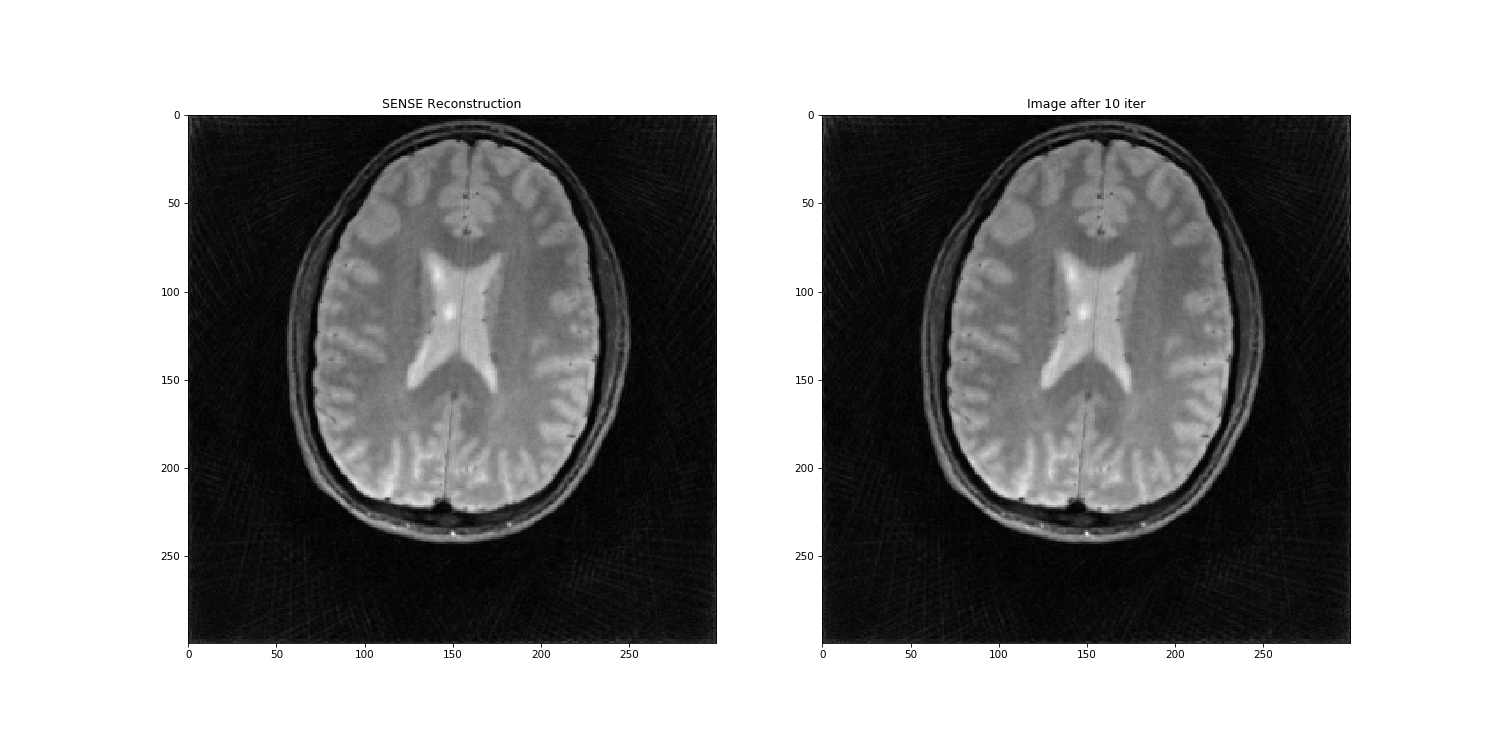

In [110]:
img_rec_now = sp.backend.to_device(img_rec_now)
im_abs_recon_now = abs(img_rec_now[0,:,:])
print(im_abs_recon_now.shape)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("SENSE Reconstruction")
plt.imshow(im_abs_recon_now[::-1,:],cmap='gray')


# plt.figure(figsize=(20,10))
plt.subplot(1,2,2)
plt.title("Image after 10 iter")
img_10_abs = np.abs(img_rec_iter10).reshape(300,300)
plt.imshow(img_10_abs[::-1,:],"gray")
plt.show()


ksp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img_rec_now[0,:,:])))
# plt.figure(figsize=(20,10))
# plt.imshow(np.abs(ksp**(1/3)),"gray")
# %matplotlib notebook
# pl.ImagePlot(ksp)





LinearLeastSquares_ref:   0%|          | 0/20 [00:00<?, ?it/s]



LinearLeastSquares_ref:   0%|          | 0/20 [00:00<?, ?it/s, obj=1.87E-02]



LinearLeastSquares_ref:   5%|▌         | 1/20 [00:00<00:11,  1.72it/s, obj=1.87E-02]



LinearLeastSquares_ref:   5%|▌         | 1/20 [00:01<00:11,  1.72it/s, obj=1.06E-02]



LinearLeastSquares_ref:  10%|█         | 2/20 [00:01<00:10,  1.75it/s, obj=1.06E-02]



LinearLeastSquares_ref:  10%|█         | 2/20 [00:01<00:10,  1.75it/s, obj=9.18E-03]



LinearLeastSquares_ref:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s, obj=9.18E-03]



LinearLeastSquares_ref:  15%|█▌        | 3/20 [00:02<00:09,  1.83it/s, obj=8.88E-03]



LinearLeastSquares_ref:  20%|██        | 4/20 [00:02<00:08,  1.86it/s, obj=8.88E-03]



LinearLeastSquares_ref:  20%|██        | 4/20 [00:02<00:08,  1.86it/s, obj=8.76E-03]



LinearLeastSquares_ref:  25%|██▌       | 5/20 [00:02<00:08,  1.87it/s, obj=8.76E-03]



LinearLeastSquares_ref:  25%|██▌       | 5/20 [00:03<00:08

<IPython.core.display.Javascript object>


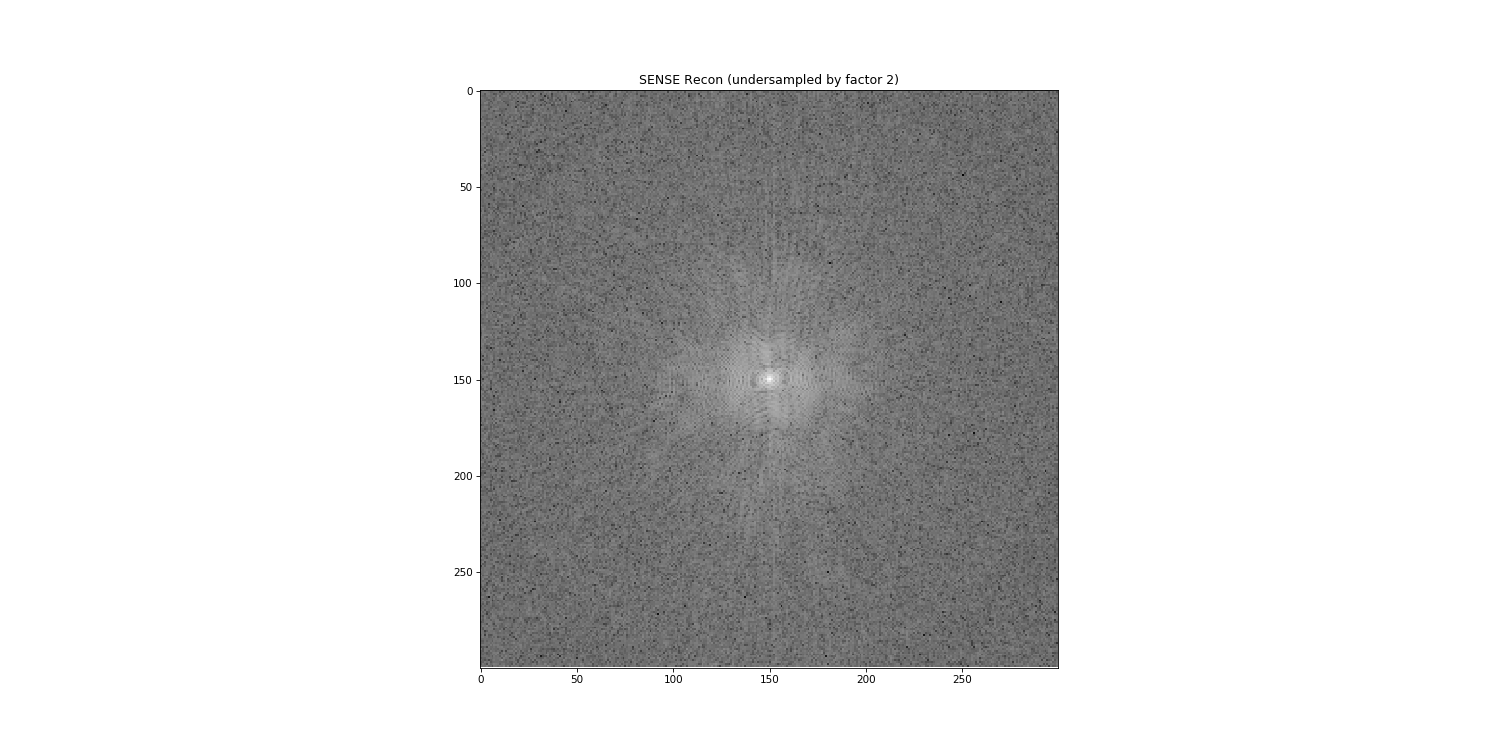

In [111]:
# Undersample
img_shape = (1,300,300)
under = 2
rawdata_brain_2 = rawdata_brain[:,:,::under]
coor_subsample_2 = coor[:,::under,:]
S_2 = sp.linop.Multiply(img_shape,sens_maps_t)
NUFFT_2 = sp.linop.NUFFT(S.oshape,coor_subsample_2)
E_2 = NUFFT_2*S_2
dcf_2 = get_dcf(coor_subsample_2)
D_2 = sp.linop.Multiply(E_2.oshape,np.sqrt(dcf_2))
# D_2 = sp.linop.Multiply(E_2.oshape,np.ones(dcf_2.shape))
A_2 = D_2*E_2
# A_2 = E_2

img_subsample_2 = LinearLeastSquares_ref(A_2,D_2*rawdata_brain_2,max_iter=20).run()
abs_img_subsample_2 = abs(img_subsample_2[0,:,:])
plt.figure(figsize=(20,10))
plt.title("SENSE Recon (undersampled by factor %d)"%under)
plt.imshow(abs_img_subsample_2[::-1,:],cmap='gray')
plt.show()

ksp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img_subsample_2[0,:,:])))
plt.imshow(np.log(np.abs(ksp)),"gray")

In [112]:
def recon_img(ksp, coord, sens_maps, under, img_shape, ref_img, niter):
    ''' Reconstruct image and plot convergence speed and residual'''
    ksp_under = ksp[:,:,::under]
    coord_under = coord[:,::under,:]
    S = sp.linop.Multiply(img_shape,sens_maps)
    NUFFT = sp.linop.NUFFT(S.oshape,coord_under)
    E = NUFFT*S
    dcf = get_dcf(coord_under)
    D = sp.linop.Multiply(E.oshape,np.sqrt(dcf))
    A = D*E
    s = LinearLeastSquares_ref(A, D*ksp_under, reference_image=ref_img, max_iter=niter, show_pbar=False)
    img = s.run()
    
    # Stats
    diff = s.diff_to_reference
    obj = s.objective_values
    res = s.res
    
    return (img, diff, obj, res)

def gridding(ksp,coord,under, img_shape):
    ''' Reconstruct image with gridding '''
    ksp_under = ksp[:,::under]
    coord_under = coord[:,::under,:]
    dcf = get_dcf(coord_under)
    ksp_dcf = ksp_under*dcf
    NUFFT = sp.linop.NUFFT(img_shape,coord_under)
    niter = 1
    s = LinearLeastSquares_ref(NUFFT, ksp_dcf, max_iter=niter, show_pbar=False)
    img = s.run()
    
    return img

# kspace filter
def fft2c(x):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))

def ifft2c(y):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(y)))


def filter(img):
#     ksp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    ksp = fft2c(img)
    kxmax = ksp.shape[0]
    kymax = ksp.shape[1]
    kx = np.arange(-kxmax/2, kxmax/2)
    ky = np.arange(-kymax/2, kymax/2)
    xx, yy = np.meshgrid(kx, ky)
    kc = kxmax/2
    k = np.sqrt(xx**2 + yy**2)
    beta = 100
    filt = 0.5 + 1/np.pi * np.arctan(beta*(kc - k)/kc)
    
    filt_ksp = filt*ksp
    img_filt = ifft2c(filt_ksp)
    
    return (filt, img_filt, filt_ksp)

<IPython.core.display.Javascript object>


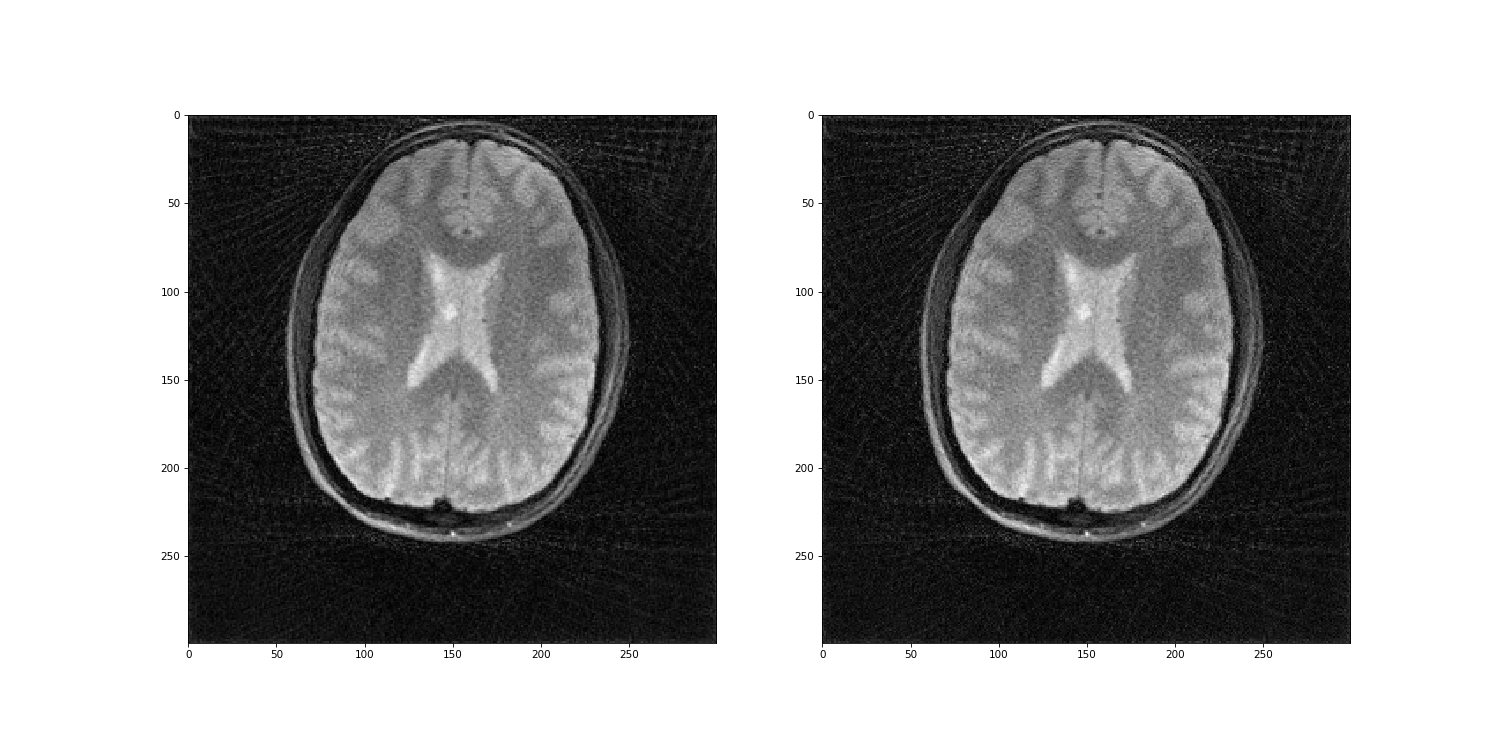

<IPython.core.display.Javascript object>


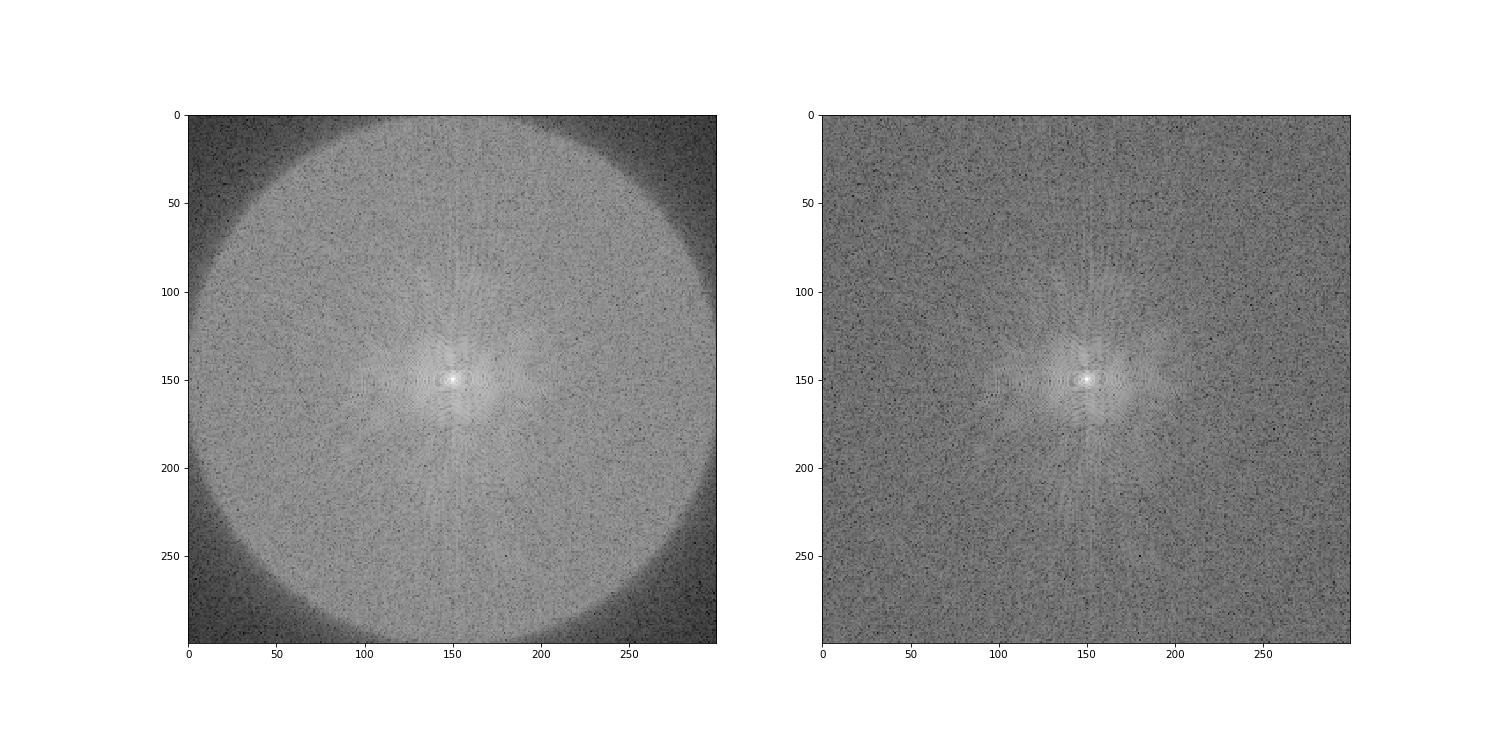

In [113]:
filt, img_filt, filt_ksp = filter(img_subsample_2[0,:,:])
img_filt_abs = np.abs(img_filt)
img_abs = np.abs(img_subsample_2[0,:,:])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_filt_abs[::-1,:],"gray")
plt.subplot(1,2,2)
plt.imshow(img_abs[::-1,:],"gray")


ksp = fft2c(img_subsample_2[0,:,:])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(filt*ksp)),"gray")
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(ksp)),"gray")





2
3
4


<IPython.core.display.Javascript object>


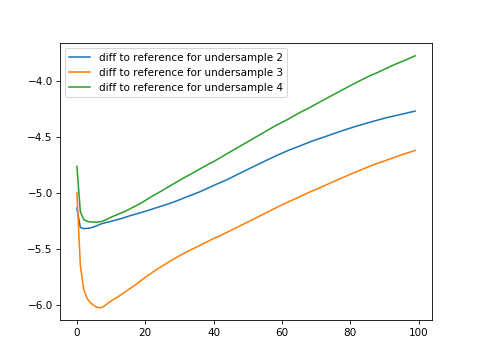

<IPython.core.display.Javascript object>


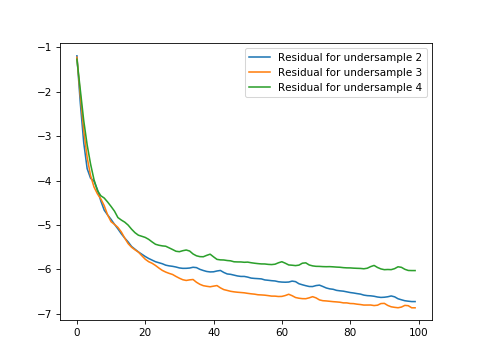

In [115]:
# Reproduce figure 4
img_shape = (1,300,300)
factors = [2,3,4]
niter = 100
diffs = np.zeros((len(factors),niter))
resids = np.zeros((len(factors),niter))
for f in factors:
    print(f)
    img, diff, obj, res = recon_img(rawdata_brain,
                                    coor,sens_maps_t,
                                    f,img_shape,
                                    img_rec_now, niter)
    diffs[f-2,:] = diff
    resids[f-2,:] = res

# Figure 4a
plt.figure()
for i in range(diffs.shape[0]):
    plt.plot(np.log(diffs[i,:]),label='diff to reference for undersample ' + str(factors[i]))
    plt.legend()
plt.show()

# Figure 4b
plt.figure()
for i in range(resids.shape[0]):
    plt.plot(np.log(resids[i,:]),label='Residual for undersample ' + str(factors[i]))
    plt.legend()
plt.show()

<IPython.core.display.Javascript object>


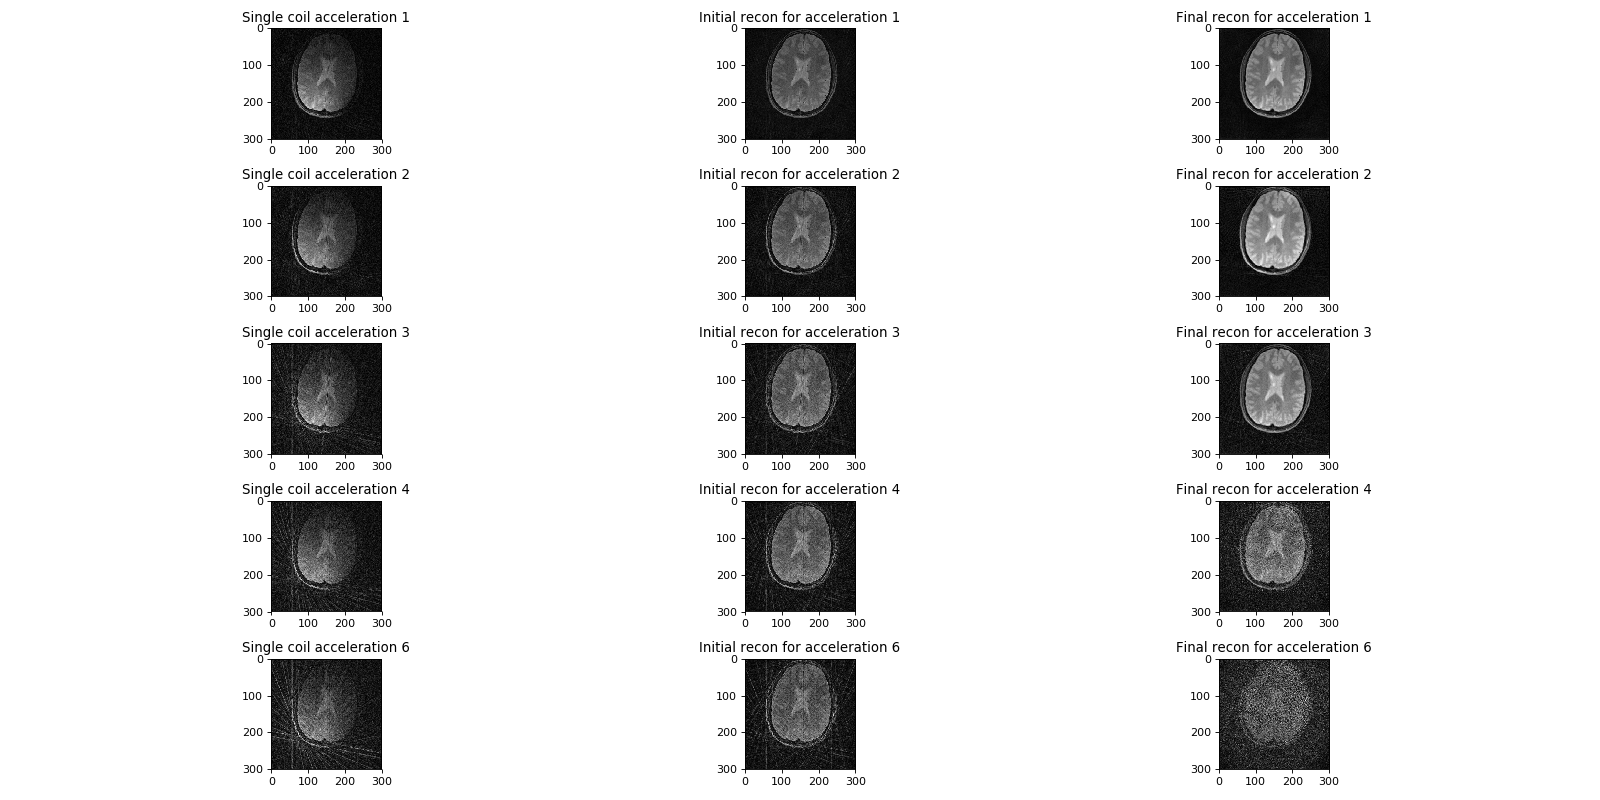

In [168]:
# Reproduce Figure 5
factors = [1,2,3,4,6]
img_shape = (300,300)
plt.figure(figsize=(20,10))
grid_ctr = 1
sense_ctr = 2
final_ctr = 3
niters = [3,6,15,50,99]
N = len(factors)

for i in range(N):
    # Gridding plot
    img_grid = gridding(rawdata_brain[0,:,:],coor,factors[i],img_shape)
    img_abs = np.abs(img_grid)
    ax1 = plt.subplot(N,3,grid_ctr)
    ax1.set_title("Single coil acceleration " + str(factors[i]))
    plt.imshow(img_abs[::-1,:],"gray")
    grid_ctr += 3
    
    # SENSE recon plot
    niter = 1
    img, diff, obj, res = recon_img(rawdata_brain,
                                    coor,sens_maps_t,
                                    factors[i],img_shape,
                                    img_rec_now, niter)
    img_abs = np.abs(img)
    ax2 = plt.subplot(N,3,sense_ctr)
    ax2.set_title("Initial recon for acceleration " + str(factors[i]))
    plt.imshow(img_abs[::-1,:],"gray")
    sense_ctr += 3
    
    # final SENSE recon plot
    niter = niters[i]
    img, diff, obj, res = recon_img(rawdata_brain,
                                    coor,sens_maps_t,
                                    factors[i],img_shape,
                                    img_rec_now, niter)
    img_abs = np.abs(img)
    ax3= plt.subplot(N,3,final_ctr)
    ax3.set_title("Final recon for acceleration "+ str(factors[i]))
    plt.imshow(img_abs[::-1,:],"gray")
    final_ctr += 3
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


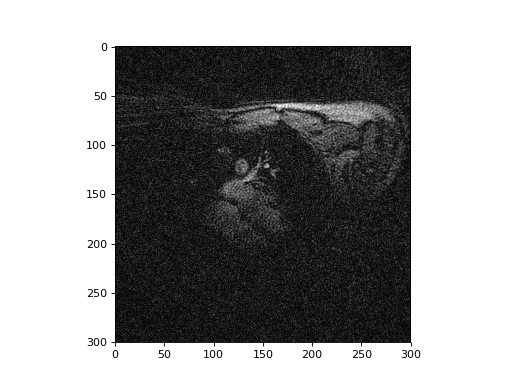

In [171]:
# Reproduce Figure 6
# read dataset: heart dataset
h5_dataset_heart = h5py.File('rawdata_heart_radial_55proj_34ch.h5', 'r')

h5_dataset_rawdata_name = list(h5_dataset_heart.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_heart.keys())[1]

trajectory = h5_dataset_heart.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_heart.get(h5_dataset_rawdata_name).value
coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_heart = rawdata[0,:,:,:].transpose((2,0,1))

img_grid = gridding(rawdata_heart,coor,1,(34,300,300))
plt.figure()
plt.imshow(np.abs(img_grid[1,:,:]),"gray")

# Grid to get maps
# img_igrid = bart(1, 'nufft -i -t', trajectory, rawdata)

# # channel combination
# img_igrid_sos = bart(1, 'rss 8', img_igrid)
# img_igrid_sos = np.abs(img_igrid_sos)
# sens_maps = img_igrid[:,:,0,:]/img_igrid_sos
# sens_maps_t = sens_maps.transpose((2,0,1))

# gpu_number = -1 # CPU 




# print("Heart ksp shape = {}".format(rawdata_heart.shape))
# print("Heart coordinate shape = {}".format(coor.shape))

# # Reconstruct
# nproj = [55, 33, 22, 11] 
# for i in range(N):
#     # SENSE recon plot
#     niter = 10
#     img, diff, obj, res = recon_img(rawdata_heart,
#                                     coor,sens_maps_t,
#                                     factors[i],img_shape,
#                                     img_rec_now, niter)
#     img_abs = np.abs(img)
#     ax2 = plt.subplot(N,3,sense_ctr)
#     ax2.set_title("Initial recon for acceleration " + str(factors[i]))
#     plt.imshow(img_abs[::-1,:],"gray")
#     sense_ctr += 3
    
#     # final SENSE recon plot
#     niter = niters[i]
#     img, diff, obj, res = recon_img(rawdata_brain,
#                                     coor,sens_maps_t,
#                                     factors[i],img_shape,
#                                     img_rec_now, niter)
#     img_abs = np.abs(img)
#     ax3= plt.subplot(N,3,final_ctr)
#     ax3.set_title("Final recon for acceleration "+ str(factors[i]))
#     plt.imshow(img_abs[::-1,:],"gray")
#     final_ctr += 3
    
# plt.tight_layout()
# plt.show()

In [137]:
rawdata_heart.shape

(34, 320, 55)

In [144]:
kspace_low_dim = np.zeros((34,300,300),dtype=np.complex)
r = 1
rate = 0.25
k = 160
cc1 = coor[int(k-k*rate):int(k+k*rate),:,:]*r
raw_low = rawdata_heart[:,int(k-k*rate):int(k+k*rate),:]

for j in range(34):
    print(j)
    raw_1 = raw_low[j,:,:][None,:,:]
    NUFFT_low = sp.linop.NUFFT((1,int(300*rate),int(300*rate)),cc1)
    lamda_l2 = 0.1
    proxg_l2 = sp.prox.L2Reg((1,int(300*rate),int(300*rate)),lamda_l2)
    img_rec_loww = sp.app.LinearLeastSquares(NUFFT_low,raw_1,proxg=proxg_l2,max_iter=100).run()
    kspace_low_dim[j,150-38:150+37,150-38:150+37] = sp.fft(img_rec_loww)[0,:,:]






MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]




MaxEig:   0%|          | 0/30 [00:00<?, ?it/s, max_eig=1.58E+02]




MaxEig:   3%|▎         | 1/30 [00:00<00:00, 38.37it/s, max_eig=4.62E+01]




MaxEig:   7%|▋         | 2/30 [00:00<00:00, 51.44it/s, max_eig=6.94E+01]




MaxEig:  10%|█         | 3/30 [00:00<00:00, 57.14it/s, max_eig=7.11E+01]




MaxEig:  13%|█▎        | 4/30 [00:00<00:00, 61.91it/s, max_eig=7.13E+01]




MaxEig:  17%|█▋        | 5/30 [00:00<00:00, 64.53it/s, max_eig=7.14E+01]




MaxEig:  20%|██        | 6/30 [00:00<00:00, 64.50it/s, max_eig=7.14E+01]




MaxEig:  23%|██▎       | 7/30 [00:00<00:00, 64.98it/s, max_eig=7.14E+01]




MaxEig:  27%|██▋       | 8/30 [00:00<00:00, 72.66it/s, max_eig=7.14E+01]




MaxEig:  27%|██▋       | 8/30 [00:00<00:00, 72.66it/s, max_eig=7.14E+01]




MaxEig:  30%|███       | 9/30 [00:00<00:00, 72.66it/s, max_eig=7.14E+01]




MaxEig:  33%|███▎      | 10/30 [00:00<00:00, 72.66it/s, max_eig=7.14E+01]




MaxEig:  37%|███▋      | 11

0







MaxEig:  43%|████▎     | 13/30 [00:00<00:00, 72.66it/s, max_eig=7.14E+01]




MaxEig:  47%|████▋     | 14/30 [00:00<00:00, 72.66it/s, max_eig=7.14E+01]




MaxEig:  50%|█████     | 15/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  50%|█████     | 15/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 70.65it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 73.53it/s, max

LinearLeastSquares:  54%|█████▍    | 54/100 [00:00<00:00, 80.61it/s, resid=3.58E-04]




LinearLeastSquares:  55%|█████▌    | 55/100 [00:00<00:00, 80.61it/s, resid=3.44E-04]




LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 80.61it/s, resid=3.30E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 80.61it/s, resid=3.18E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 80.61it/s, resid=3.06E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 80.61it/s, resid=2.94E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 80.61it/s, resid=2.83E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 82.38it/s, resid=2.83E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 82.38it/s, resid=2.73E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 82.38it/s, resid=2.63E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 82.38it/s, resid=2.53E-04]




LinearLeastSquares:  

1







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.76it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 85.76it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 85.16it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.91it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 82.23it/s, resid=3.13E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 82.23it/s, resid=3.01E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 82.23it/s, resid=2.89E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 82.23it/s, resid=2.78E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 82.23it/s, resid=2.68E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 82.23it/s, resid=2.58E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 82.23it/s, resid=2.49E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 81.63it/s, resid=2.49E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 81.63it/s, resid=2.39E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 81.63it/s, resid=2.31E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 81.63it/s, resid=2.23E-04]




LinearLeastSquares:  

2







MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 89.62it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 89.62it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 89.86it/s, max_eig=7.14E+01]




MaxEig:  93%|█████████▎| 28/30 [00:00<00:00, 87.53it/s, max

LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 83.40it/s, resid=5.69E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 83.40it/s, resid=5.51E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 83.40it/s, resid=5.33E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 83.40it/s, resid=5.17E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 83.40it/s, resid=5.01E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 82.63it/s, resid=5.01E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 82.63it/s, resid=4.85E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 82.63it/s, resid=4.71E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 82.63it/s, resid=4.57E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 82.63it/s, resid=4.43E-05]




LinearLeastSquares:  66%|██████▌   | 66/100 [00:00<00:00, 82.63it/s, resid=4.30E-05]




LinearLeastSquares:  

3







MaxEig:  47%|████▋     | 14/30 [00:00<00:00, 66.87it/s, max_eig=7.14E+01]




MaxEig:  50%|█████     | 15/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  50%|█████     | 15/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 70.28it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 74.61it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 74.61it/s, max

LinearLeastSquares:  55%|█████▌    | 55/100 [00:00<00:00, 83.53it/s, resid=8.21E-05]




LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 83.53it/s, resid=7.94E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 83.53it/s, resid=7.67E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 83.53it/s, resid=7.41E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 83.53it/s, resid=7.17E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 83.53it/s, resid=6.94E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 82.16it/s, resid=6.94E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 82.16it/s, resid=6.71E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 82.16it/s, resid=6.50E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 82.16it/s, resid=6.29E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 82.16it/s, resid=6.09E-05]




LinearLeastSquares:  

4







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 78.84it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 78.65it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 78.25it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 89.05it/s, resid=1.14E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 89.05it/s, resid=1.10E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 89.05it/s, resid=1.06E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 89.05it/s, resid=1.02E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 89.05it/s, resid=9.80E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 89.05it/s, resid=9.45E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 89.05it/s, resid=9.10E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 89.05it/s, resid=8.78E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 89.08it/s, resid=8.78E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 89.08it/s, resid=8.46E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 89.08it/s, resid=8.17E-05]




LinearLeastSquares:  

5







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 79.92it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 79.32it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 78.75it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 78.75it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 78.75it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 79.27it/s, resid=7.95E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.27it/s, resid=7.67E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 76.24it/s, resid=7.67E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 76.24it/s, resid=7.40E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 76.24it/s, resid=7.15E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 76.24it/s, resid=6.90E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 76.24it/s, resid=6.67E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 76.24it/s, resid=6.44E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 76.24it/s, resid=6.23E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 76.24it/s, resid=6.02E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 76.24it/s, resid=5.82E-05]




LinearLeastSquares:  

6







MaxEig:  60%|██████    | 18/30 [00:00<00:00, 92.09it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 92.09it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  93%|█████████▎| 28/30 [00:00<00:00, 91.89it/s, max_eig=7.14E+01]




MaxEig:  97%|█████████▋| 29/30 [00:00<00:00, 91.89it/s, max

LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 81.49it/s, resid=7.57E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 81.49it/s, resid=7.34E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.39it/s, resid=7.34E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.39it/s, resid=7.11E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.39it/s, resid=6.88E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.39it/s, resid=6.67E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.39it/s, resid=6.47E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.39it/s, resid=6.27E-05]




LinearLeastSquares:  66%|██████▌   | 66/100 [00:00<00:00, 80.39it/s, resid=6.09E-05]




LinearLeastSquares:  67%|██████▋   | 67/100 [00:00<00:00, 80.39it/s, resid=5.91E-05]




LinearLeastSquares:  68%|██████▊   | 68/100 [00:00<00:00, 80.39it/s, resid=5.73E-05]




LinearLeastSquares:  

7







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 80.91it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 80.91it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.24it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 81.28it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 78.33it/s, resid=4.67E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 78.33it/s, resid=4.52E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 78.33it/s, resid=4.38E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 78.33it/s, resid=4.25E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 78.33it/s, resid=4.12E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.71it/s, resid=4.12E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.71it/s, resid=3.99E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 79.71it/s, resid=3.88E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 79.71it/s, resid=3.76E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 79.71it/s, resid=3.65E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 79.71it/s, resid=3.55E-05]




LinearLeastSquares:  

8


MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 82.41it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 82.41it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 84.15it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.85it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.85it/s, max_eig=

LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.91it/s, resid=2.17E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 79.91it/s, resid=2.09E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 79.91it/s, resid=2.02E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 79.91it/s, resid=1.94E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.43it/s, resid=1.94E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.43it/s, resid=1.87E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.43it/s, resid=1.80E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.43it/s, resid=1.74E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.43it/s, resid=1.68E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.43it/s, resid=1.62E-04]




LinearLeastSquares:  66%|██████▌   | 66/100 [00:00<00:00, 80.43it/s, resid=1.56E-04]




LinearLeastSquares:  

9







MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 91.85it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 91.85it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 90.96it/s, max_eig=7.14E+01]




MaxEig:  93%|█████████▎| 28/30 [00:00<00:00, 90.96it/s, max

LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 85.51it/s, resid=1.10E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 85.51it/s, resid=1.06E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 85.51it/s, resid=1.02E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 85.51it/s, resid=9.79E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 85.51it/s, resid=9.43E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 85.51it/s, resid=9.09E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 84.16it/s, resid=9.09E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 84.16it/s, resid=8.76E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 84.16it/s, resid=8.45E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 84.16it/s, resid=8.15E-05]




LinearLeastSquares:  66%|██████▌   | 66/100 [00:00<00:00, 84.16it/s, resid=7.87E-05]




LinearLeastSquares:  

10







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 75.37it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 75.85it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 75.39it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 75.39it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 75.39it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 73.78it/s, resid=2.73E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 73.78it/s, resid=2.67E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 73.78it/s, resid=2.60E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 79.60it/s, resid=2.60E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 79.60it/s, resid=2.54E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 79.60it/s, resid=2.49E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.60it/s, resid=2.43E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 79.60it/s, resid=2.38E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 79.60it/s, resid=2.33E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 79.60it/s, resid=2.28E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 79.60it/s, resid=2.23E-04]




LinearLeastSquares:  

11







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 78.98it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 77.81it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 76.92it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 76.92it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 76.92it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 78.34it/s, resid=4.58E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 78.97it/s, resid=4.58E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 78.97it/s, resid=4.42E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 78.97it/s, resid=4.27E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 78.97it/s, resid=4.12E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 78.97it/s, resid=3.98E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 78.97it/s, resid=3.85E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 78.97it/s, resid=3.72E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 78.97it/s, resid=3.61E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 78.97it/s, resid=3.49E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 79.05it/s, resid=3.49E-04]




LinearLeastSquares:  

12







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 84.73it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 83.20it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 79.86it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 79.86it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 79.86it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 78.61it/s, resid=6.53E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 78.61it/s, resid=6.28E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 78.61it/s, resid=6.03E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 78.61it/s, resid=5.80E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 78.61it/s, resid=5.58E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.07it/s, resid=5.58E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.07it/s, resid=5.36E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 79.07it/s, resid=5.16E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 79.07it/s, resid=4.97E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 79.07it/s, resid=4.78E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 79.07it/s, resid=4.60E-04]




LinearLeastSquares:  

13







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 82.75it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 82.75it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 82.81it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.64it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.64it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 80.00it/s, resid=3.61E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 80.00it/s, resid=3.47E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 80.00it/s, resid=3.34E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 80.00it/s, resid=3.21E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 78.70it/s, resid=3.21E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 78.70it/s, resid=3.09E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 78.70it/s, resid=2.97E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 78.70it/s, resid=2.86E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 78.70it/s, resid=2.75E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 78.70it/s, resid=2.65E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 78.70it/s, resid=2.55E-04]




LinearLeastSquares:  

14







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 79.54it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 78.25it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 77.80it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 77.80it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 77.80it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 74.65it/s, resid=9.62E-05]




LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 74.65it/s, resid=9.33E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 74.65it/s, resid=9.06E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 74.65it/s, resid=8.79E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 74.65it/s, resid=8.54E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 74.65it/s, resid=8.30E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 74.65it/s, resid=8.07E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 74.65it/s, resid=7.84E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 74.65it/s, resid=7.63E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 74.36it/s, resid=7.63E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 74.36it/s, resid=7.43E-05]




LinearLeastSquares:  

15







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 84.86it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 84.86it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 84.59it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.45it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 77.23it/s, resid=5.62E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 74.85it/s, resid=5.62E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 74.85it/s, resid=5.45E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 74.85it/s, resid=5.29E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 74.85it/s, resid=5.13E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 74.85it/s, resid=4.98E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 74.85it/s, resid=4.84E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 74.85it/s, resid=4.70E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 74.85it/s, resid=4.57E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 74.85it/s, resid=4.44E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 75.54it/s, resid=4.44E-05]




LinearLeastSquares:  

16







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.66it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 85.66it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 85.03it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.58it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 81.13it/s, resid=2.04E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 81.13it/s, resid=1.96E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 81.13it/s, resid=1.89E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 81.13it/s, resid=1.82E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 81.13it/s, resid=1.75E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 81.13it/s, resid=1.69E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.68it/s, resid=1.69E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.68it/s, resid=1.63E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.68it/s, resid=1.57E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.68it/s, resid=1.52E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.68it/s, resid=1.46E-04]




LinearLeastSquares:  

17







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.18it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 85.18it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 84.54it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.38it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 81.17it/s, resid=2.06E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 81.17it/s, resid=1.98E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 81.17it/s, resid=1.91E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 81.17it/s, resid=1.84E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 81.17it/s, resid=1.77E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 81.17it/s, resid=1.71E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 81.08it/s, resid=1.71E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 81.08it/s, resid=1.65E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 81.08it/s, resid=1.59E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 81.08it/s, resid=1.53E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 81.08it/s, resid=1.48E-04]




LinearLeastSquares:  

18







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 79.67it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 79.67it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 77.85it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 78.79it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 77.17it/s, resid=4.99E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 77.17it/s, resid=4.84E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 77.85it/s, resid=4.84E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 77.85it/s, resid=4.69E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 77.85it/s, resid=4.55E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 77.85it/s, resid=4.41E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 77.85it/s, resid=4.28E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 77.85it/s, resid=4.15E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 77.85it/s, resid=4.03E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 77.85it/s, resid=3.91E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 77.85it/s, resid=3.80E-05]




LinearLeastSquares:  

19







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 83.45it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 83.45it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 82.87it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.02it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.02it/s, max

LinearLeastSquares:  55%|█████▌    | 55/100 [00:00<00:00, 76.41it/s, resid=7.13E-05]




LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 76.41it/s, resid=6.91E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 76.41it/s, resid=6.71E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 76.41it/s, resid=6.51E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 76.41it/s, resid=6.32E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 76.41it/s, resid=6.14E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 76.41it/s, resid=5.97E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 76.41it/s, resid=5.80E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 76.63it/s, resid=5.80E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 76.63it/s, resid=5.64E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 76.63it/s, resid=5.49E-05]




LinearLeastSquares:  

20







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 82.74it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 82.74it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 82.55it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 82.02it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 77.28it/s, resid=2.31E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 77.28it/s, resid=2.24E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 79.36it/s, resid=2.24E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 79.36it/s, resid=2.17E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 79.36it/s, resid=2.11E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 79.36it/s, resid=2.05E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.36it/s, resid=1.99E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 79.36it/s, resid=1.93E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 79.36it/s, resid=1.88E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 79.36it/s, resid=1.83E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 79.36it/s, resid=1.78E-04]




LinearLeastSquares:  

21







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 84.08it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 84.08it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 84.12it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.06it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 79.17it/s, resid=2.52E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.17it/s, resid=2.45E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 79.17it/s, resid=2.40E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 79.17it/s, resid=2.34E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 80.10it/s, resid=2.34E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 80.10it/s, resid=2.29E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.10it/s, resid=2.24E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.10it/s, resid=2.19E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.10it/s, resid=2.14E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.10it/s, resid=2.09E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.10it/s, resid=2.05E-04]




LinearLeastSquares:  

22







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.83it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 82.84it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 79.29it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 79.29it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 79.29it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 75.68it/s, resid=7.52E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 75.68it/s, resid=7.29E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 75.61it/s, resid=7.29E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 75.61it/s, resid=7.08E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 75.61it/s, resid=6.87E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 75.61it/s, resid=6.67E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 75.61it/s, resid=6.48E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 75.61it/s, resid=6.30E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 75.61it/s, resid=6.13E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 75.61it/s, resid=5.96E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 75.61it/s, resid=5.80E-05]




LinearLeastSquares:  

23







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.46it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 85.46it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 84.57it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.34it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 80.47it/s, resid=8.75E-05]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 80.47it/s, resid=8.43E-05]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 80.47it/s, resid=8.13E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 80.47it/s, resid=7.84E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 80.50it/s, resid=7.84E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 80.50it/s, resid=7.56E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.50it/s, resid=7.30E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.50it/s, resid=7.05E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.50it/s, resid=6.81E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.50it/s, resid=6.58E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.50it/s, resid=6.36E-05]




LinearLeastSquares:  

24







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 82.86it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 81.28it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.52it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.52it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 81.78it/s, resid=5.71E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 81.78it/s, resid=5.47E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 81.78it/s, resid=5.24E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 81.78it/s, resid=5.03E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 81.78it/s, resid=4.82E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 81.78it/s, resid=4.63E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 81.90it/s, resid=4.63E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 81.90it/s, resid=4.44E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 81.90it/s, resid=4.27E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 81.90it/s, resid=4.10E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 81.90it/s, resid=3.94E-04]




LinearLeastSquares:  

25







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.72it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 85.72it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 85.17it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 84.87it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 79.58it/s, resid=5.16E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.58it/s, resid=4.96E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 79.58it/s, resid=4.76E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 78.70it/s, resid=4.76E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 78.70it/s, resid=4.57E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 78.70it/s, resid=4.39E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 78.70it/s, resid=4.22E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 78.70it/s, resid=4.06E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 78.70it/s, resid=3.90E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 78.70it/s, resid=3.75E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 78.70it/s, resid=3.61E-04]




LinearLeastSquares:  

26







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 79.13it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 80.34it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.35it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.35it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 75.47it/s, resid=1.19E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 73.00it/s, resid=1.19E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 73.00it/s, resid=1.14E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 73.00it/s, resid=1.10E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 73.00it/s, resid=1.05E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 73.00it/s, resid=1.01E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 73.00it/s, resid=9.77E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 73.00it/s, resid=9.41E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 73.00it/s, resid=9.06E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 73.00it/s, resid=8.73E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 73.00it/s, resid=8.42E-05]




LinearLeastSquares:  

27







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 76.95it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 76.95it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 79.01it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 82.01it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 79.01it/s, resid=1.07E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.01it/s, resid=1.03E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 81.10it/s, resid=1.03E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 81.10it/s, resid=9.91E-05]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 81.10it/s, resid=9.54E-05]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 81.10it/s, resid=9.18E-05]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 81.10it/s, resid=8.84E-05]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 81.10it/s, resid=8.52E-05]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 81.10it/s, resid=8.21E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 81.10it/s, resid=7.92E-05]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 81.10it/s, resid=7.63E-05]




LinearLeastSquares:  

28







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 76.31it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 76.46it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 75.12it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 75.12it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 75.12it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 79.26it/s, resid=3.94E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.26it/s, resid=3.84E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 79.26it/s, resid=3.74E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 79.26it/s, resid=3.64E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 79.26it/s, resid=3.55E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 79.26it/s, resid=3.47E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.58it/s, resid=3.47E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.58it/s, resid=3.38E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.58it/s, resid=3.31E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.58it/s, resid=3.23E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.58it/s, resid=3.16E-04]




LinearLeastSquares:  

29







MaxEig:  50%|█████     | 15/30 [00:00<00:00, 71.65it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 71.65it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 74.87it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 74.51it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 74.51it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 77.56it/s, resid=2.63E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 77.53it/s, resid=2.63E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 77.53it/s, resid=2.54E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 77.53it/s, resid=2.46E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 77.53it/s, resid=2.38E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 77.53it/s, resid=2.30E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 77.53it/s, resid=2.23E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 77.53it/s, resid=2.16E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 77.53it/s, resid=2.10E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 77.53it/s, resid=2.04E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 77.44it/s, resid=2.04E-04]




LinearLeastSquares:  

30







MaxEig:  47%|████▋     | 14/30 [00:00<00:00, 75.44it/s, max_eig=7.14E+01]




MaxEig:  50%|█████     | 15/30 [00:00<00:00, 75.44it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 74.38it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 74.24it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 74.24it/s, max

LinearLeastSquares:  55%|█████▌    | 55/100 [00:00<00:00, 79.01it/s, resid=1.28E-04]




LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 79.01it/s, resid=1.24E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 79.01it/s, resid=1.20E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 75.55it/s, resid=1.20E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 75.55it/s, resid=1.16E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 75.55it/s, resid=1.12E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 75.55it/s, resid=1.08E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 75.55it/s, resid=1.05E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 75.55it/s, resid=1.01E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 75.55it/s, resid=9.82E-05]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 75.55it/s, resid=9.51E-05]




LinearLeastSquares:  

31







MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 88.40it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 86.48it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.67it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 81.67it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 81.67it/s, max

LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 74.96it/s, resid=1.31E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 74.96it/s, resid=1.28E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 74.20it/s, resid=1.28E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 74.20it/s, resid=1.24E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 74.20it/s, resid=1.21E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 74.20it/s, resid=1.18E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 74.20it/s, resid=1.15E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 74.20it/s, resid=1.13E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 74.20it/s, resid=1.10E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 74.20it/s, resid=1.08E-04]




LinearLeastSquares:  66%|██████▌   | 66/100 [00:00<00:00, 74.20it/s, resid=1.05E-04]




LinearLeastSquares:  

32







MaxEig:  47%|████▋     | 14/30 [00:00<00:00, 71.07it/s, max_eig=7.14E+01]




MaxEig:  50%|█████     | 15/30 [00:00<00:00, 71.07it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 71.97it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 73.96it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 73.96it/s, max

LinearLeastSquares:  55%|█████▌    | 55/100 [00:00<00:00, 82.54it/s, resid=3.56E-04]




LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 82.54it/s, resid=3.43E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 82.54it/s, resid=3.30E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 82.54it/s, resid=3.17E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 82.54it/s, resid=3.06E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 82.54it/s, resid=2.94E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.07it/s, resid=2.94E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.07it/s, resid=2.84E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.07it/s, resid=2.73E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.07it/s, resid=2.63E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.07it/s, resid=2.54E-04]




LinearLeastSquares:  

33







MaxEig:  53%|█████▎    | 16/30 [00:00<00:00, 85.85it/s, max_eig=7.14E+01]




MaxEig:  57%|█████▋    | 17/30 [00:00<00:00, 85.85it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  60%|██████    | 18/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  63%|██████▎   | 19/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  67%|██████▋   | 20/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  70%|███████   | 21/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  73%|███████▎  | 22/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  77%|███████▋  | 23/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  80%|████████  | 24/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  83%|████████▎ | 25/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  87%|████████▋ | 26/30 [00:00<00:00, 85.40it/s, max_eig=7.14E+01]




MaxEig:  90%|█████████ | 27/30 [00:00<00:00, 85.00it/s, max

LinearLeastSquares:  56%|█████▌    | 56/100 [00:00<00:00, 80.02it/s, resid=2.42E-04]




LinearLeastSquares:  57%|█████▋    | 57/100 [00:00<00:00, 80.02it/s, resid=2.33E-04]




LinearLeastSquares:  58%|█████▊    | 58/100 [00:00<00:00, 80.02it/s, resid=2.25E-04]




LinearLeastSquares:  59%|█████▉    | 59/100 [00:00<00:00, 80.02it/s, resid=2.16E-04]




LinearLeastSquares:  60%|██████    | 60/100 [00:00<00:00, 80.02it/s, resid=2.08E-04]




LinearLeastSquares:  61%|██████    | 61/100 [00:00<00:00, 80.02it/s, resid=2.01E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.24it/s, resid=2.01E-04]




LinearLeastSquares:  62%|██████▏   | 62/100 [00:00<00:00, 80.24it/s, resid=1.93E-04]




LinearLeastSquares:  63%|██████▎   | 63/100 [00:00<00:00, 80.24it/s, resid=1.86E-04]




LinearLeastSquares:  64%|██████▍   | 64/100 [00:00<00:00, 80.24it/s, resid=1.80E-04]




LinearLeastSquares:  65%|██████▌   | 65/100 [00:00<00:00, 80.24it/s, resid=1.73E-04]




LinearLeastSquares:  

In [147]:
import bart 

In [151]:
kl = kspace_low_dim.transpose(1,2,0)[:,:,None,:]

In [152]:
sens = bart.bart(1,"ecalib -a -m1",kl)

In [155]:
sens.shape

(300, 300, 1, 34)

In [156]:
sens_map = sens[:,:,0,:].transpose(2,0,1)

<IPython.core.display.Javascript object>


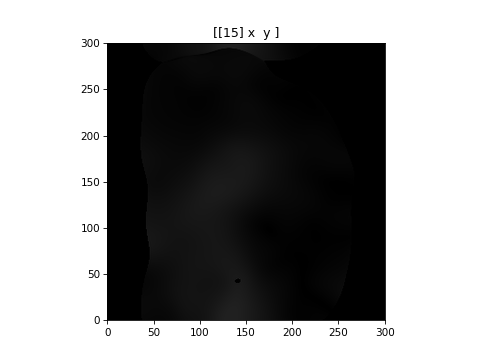

In [158]:
pl.ImagePlot(sens_map)

In [160]:
rawdata_heart.shape

(34, 320, 55)

In [162]:
NUFFT_2.oshape

[12, 320, 28]

In [175]:
# Subsample of the radial data
#L_2 Normalization
lamda_l2 = 0.1
under = 5
proxg_l2 = sp.prox.L2Reg((1,300,300),lamda_l2)
coor_subsample_2 = coor[:,::under,:]
# phase = np.exp(1j*np.pi*(0)*coor_subsample_2[:,:,0][None,:,:])
# phase = sp.backend.to_device(phase,gpu_number)
rawdata_brain_2 = rawdata_heart[:,:,::under]
rawdata_brain_2 = sp.backend.to_device(rawdata_brain_2,-1)
# pl.ScatterPlot(coor_subsample_2)
S_2 = sp.linop.Multiply((1,300,300),sens_map)
NUFFT_2 = sp.linop.NUFFT((34,300,300),coor_subsample_2*r)
Operator_2 = NUFFT_2*S_2
img_rec_now_2 = sp.app.LinearLeastSquares(Operator_2,rawdata_brain_2,proxg=proxg_l2,max_iter=100).run()
img_rec_now_2 = sp.backend.to_device(img_rec_now_2)
im_abs_recon_now_2 = abs(img_rec_now_2[0,:,:])









MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]






MaxEig:   0%|          | 0/30 [00:00<?, ?it/s, max_eig=3.36E+01]






MaxEig:   3%|▎         | 1/30 [00:00<00:21,  1.36it/s, max_eig=3.36E+01]






MaxEig:   3%|▎         | 1/30 [00:01<00:21,  1.36it/s, max_eig=1.17E+00]






MaxEig:   7%|▋         | 2/30 [00:01<00:20,  1.38it/s, max_eig=1.17E+00]






MaxEig:   7%|▋         | 2/30 [00:02<00:20,  1.38it/s, max_eig=4.02E+00]






MaxEig:  10%|█         | 3/30 [00:02<00:19,  1.37it/s, max_eig=4.02E+00]






MaxEig:  10%|█         | 3/30 [00:02<00:19,  1.37it/s, max_eig=5.13E+00]






MaxEig:  13%|█▎        | 4/30 [00:02<00:19,  1.36it/s, max_eig=5.13E+00]






MaxEig:  13%|█▎        | 4/30 [00:03<00:19,  1.36it/s, max_eig=5.35E+00]






MaxEig:  17%|█▋        | 5/30 [00:03<00:18,  1.35it/s, max_eig=5.35E+00]






MaxEig:  17%|█▋        | 5/30 [00:04<00:18,  1.35it/s, max_eig=5.44E+00]






MaxEig:  20%|██        | 6/30 [00:04<00:17,  1.38it/s, max_eig=5.44E+00]








LinearLeastSquares:   9%|▉         | 9/100 [00:07<01:12,  1.25it/s, resid=1.17E-03]






LinearLeastSquares:  10%|█         | 10/100 [00:07<01:10,  1.28it/s, resid=1.17E-03]






LinearLeastSquares:  10%|█         | 10/100 [00:08<01:10,  1.28it/s, resid=9.69E-04]






LinearLeastSquares:  11%|█         | 11/100 [00:08<01:12,  1.23it/s, resid=9.69E-04]






LinearLeastSquares:  11%|█         | 11/100 [00:09<01:12,  1.23it/s, resid=8.10E-04]






LinearLeastSquares:  12%|█▏        | 12/100 [00:09<01:11,  1.24it/s, resid=8.10E-04]






LinearLeastSquares:  12%|█▏        | 12/100 [00:10<01:11,  1.24it/s, resid=6.84E-04]






LinearLeastSquares:  13%|█▎        | 13/100 [00:10<01:09,  1.25it/s, resid=6.84E-04]






LinearLeastSquares:  13%|█▎        | 13/100 [00:10<01:09,  1.25it/s, resid=5.84E-04]






LinearLeastSquares:  14%|█▍        | 14/100 [00:10<01:06,  1.29it/s, resid=5.84E-04]






LinearLeastSquares:  14%|█▍        | 14/100 [00:11<01:06,  1.29it/s, resid=5.04E-04]








LinearLeastSquares:  46%|████▌     | 46/100 [00:35<00:39,  1.35it/s, resid=3.93E-05]






LinearLeastSquares:  46%|████▌     | 46/100 [00:35<00:39,  1.35it/s, resid=3.71E-05]






LinearLeastSquares:  47%|████▋     | 47/100 [00:35<00:39,  1.35it/s, resid=3.71E-05]






LinearLeastSquares:  47%|████▋     | 47/100 [00:36<00:39,  1.35it/s, resid=3.51E-05]






LinearLeastSquares:  48%|████▊     | 48/100 [00:36<00:38,  1.34it/s, resid=3.51E-05]






LinearLeastSquares:  48%|████▊     | 48/100 [00:37<00:38,  1.34it/s, resid=3.32E-05]






LinearLeastSquares:  49%|████▉     | 49/100 [00:37<00:37,  1.35it/s, resid=3.32E-05]






LinearLeastSquares:  49%|████▉     | 49/100 [00:38<00:37,  1.35it/s, resid=3.14E-05]






LinearLeastSquares:  50%|█████     | 50/100 [00:38<00:38,  1.31it/s, resid=3.14E-05]






LinearLeastSquares:  50%|█████     | 50/100 [00:38<00:38,  1.31it/s, resid=2.97E-05]






LinearLeastSquares:  51%|█████     | 51/100 [00:38<00:38,  1.28it/s, resid=2.97E-05]







LinearLeastSquares:  82%|████████▏ | 82/100 [01:02<00:13,  1.36it/s, resid=6.14E-06]






LinearLeastSquares:  83%|████████▎ | 83/100 [01:02<00:12,  1.35it/s, resid=6.14E-06]






LinearLeastSquares:  83%|████████▎ | 83/100 [01:03<00:12,  1.35it/s, resid=5.87E-06]






LinearLeastSquares:  84%|████████▍ | 84/100 [01:03<00:11,  1.39it/s, resid=5.87E-06]






LinearLeastSquares:  84%|████████▍ | 84/100 [01:04<00:11,  1.39it/s, resid=5.61E-06]






LinearLeastSquares:  85%|████████▌ | 85/100 [01:04<00:10,  1.40it/s, resid=5.61E-06]






LinearLeastSquares:  85%|████████▌ | 85/100 [01:04<00:10,  1.40it/s, resid=5.36E-06]






LinearLeastSquares:  86%|████████▌ | 86/100 [01:04<00:10,  1.36it/s, resid=5.36E-06]






LinearLeastSquares:  86%|████████▌ | 86/100 [01:05<00:10,  1.36it/s, resid=5.12E-06]






LinearLeastSquares:  87%|████████▋ | 87/100 [01:05<00:09,  1.34it/s, resid=5.12E-06]






LinearLeastSquares:  87%|████████▋ | 87/100 [01:06<00:09,  1.34it/s, resid=4.90E-06]







<IPython.core.display.Javascript object>


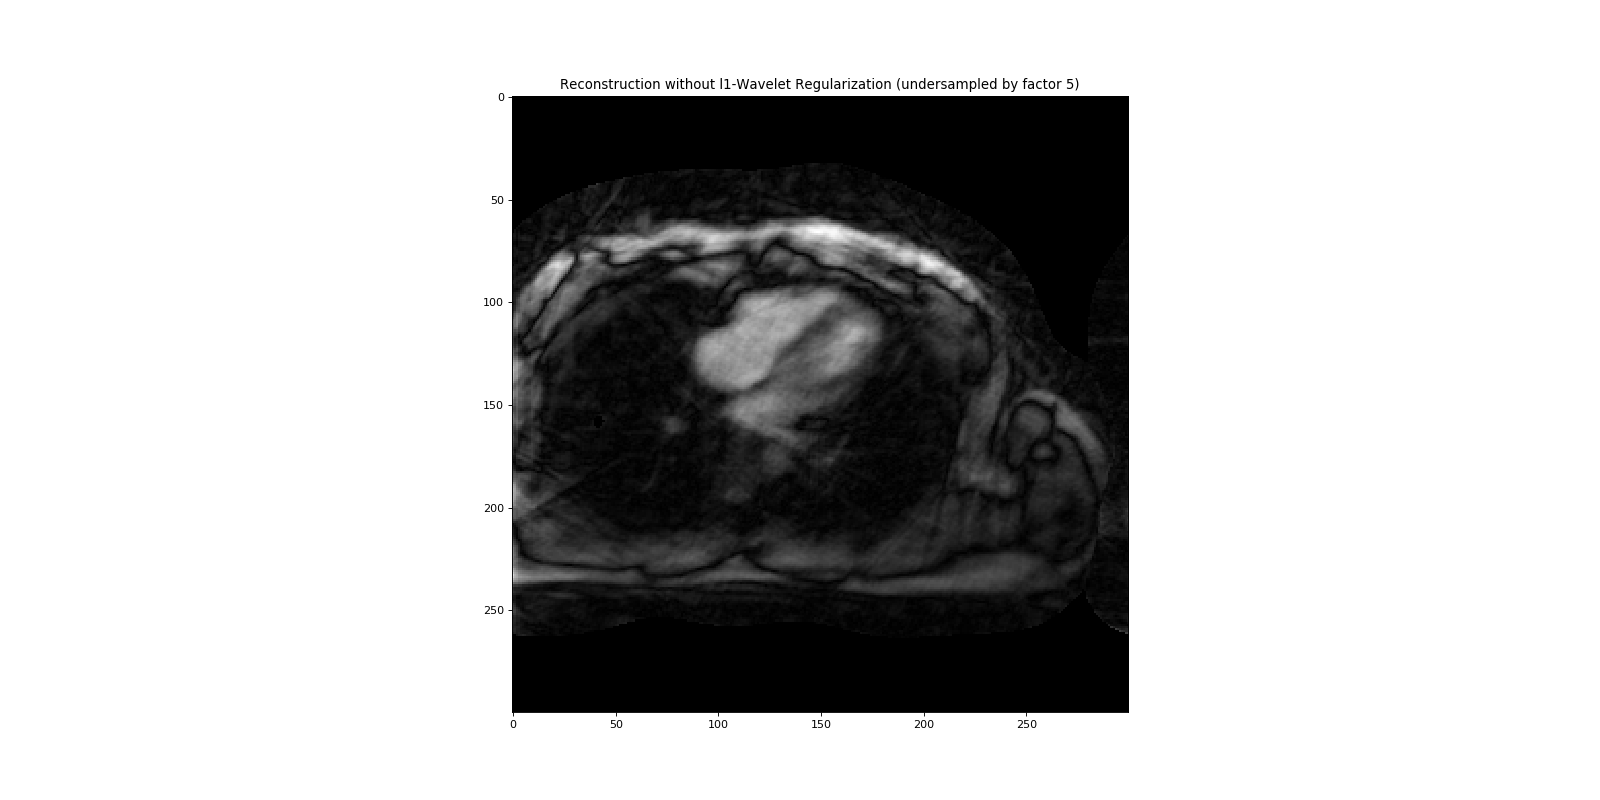

In [176]:
plt.figure(figsize=(20,10))
plt.title("Reconstruction without l1-Wavelet Regularization (undersampled by factor %d)"%under)
plt.imshow(im_abs_recon_now_2[::-1,:],cmap='gray')
plt.show()